In [2]:
!pip install pyroomacoustics


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import pyroomacoustics as pra  # usamos paquete pyroomacoustics para generar RIR de salas
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import layers, models
from scipy import signal
from IPython.display import Audio, display
import time
import os
#import seaborn as sns



In [4]:
PATH = 'Models'

In [22]:
# Generamos el sistema acústico

# Dimensiones de la sala (ancho x largo x alto) en metros
room_dim = [3, 4, 2]

# Crear la sala utilizando el método de las imágenes
# rt60 es el tiempo de reverberación objetivo en segundos (RT60)
rt60 = [0.15, 0.175, 0.2, 0.225, 0.25]   # Tiempo de reverberación objetivo en segundos (5 modelos de salas diferentes)

# Creamos sólo modelo de sala de rt60 = 0.2 s
e_absorption, max_order = pra.inverse_sabine(rt60[2], room_dim)  # Obtenemos la absorción de los materiales de las paredes y el orden del modelo FIR necesario
fs=2000  # En el artículo es 16000, pero para reducir computación lo fijamos a 2000
# Creamos la sala rectangular
room = pra.ShoeBox(
    room_dim,
    fs=fs,                # Frecuencia de muestreo (Hz)
    materials=pra.Material(e_absorption),  # Material con absorción
    max_order=max_order      # Orden máximo del método de imágenes
)


# Añadimos elementos del sistema:
# Fuente de ruido:
noise_location = [1.5, 1, 1]  # Coordenadas de la fuente de ruido
room.add_source(noise_location)


# Altavoz secundario
loudspeaker_location = [1.5, 2.5, 1]  # Coordenadas del altavoz secundario
room.add_source(loudspeaker_location)


# micrófono de control
mic_location = [1.5, 3, 1]  # Coordenadas del micrófono

room.add_microphone_array(pra.MicrophoneArray(np.array([mic_location]).T, room.fs))
room.compute_rir()

# Obtener las respuesta al impulso (RIR) de cada canal
p_rir = room.rir[0][0]  # Primer micrófono, Primera fuente (camino primario entre fuente de ruido y micrófono)
s_rir = room.rir[0][1]  # Primer micrófono, Segunda fuente (camino secundario entre altavoz y micrófono)

p_rir=p_rir[0:500]
s_rir=s_rir[41:541] #Quitamos retardo inicial
s_rir2 = np.concatenate((np.zeros(160),s_rir))

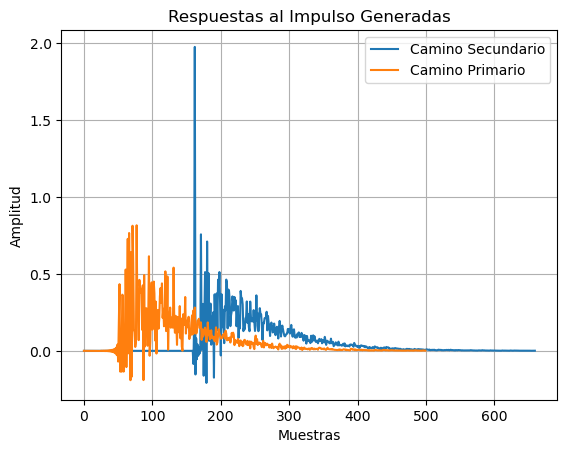

In [30]:


plt.figure()
plt.plot(s_rir2)
plt.plot(p_rir)
plt.title("Respuestas al Impulso Generadas")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend(['Camino Secundario', 'Camino Primario'])
plt.grid()

In [23]:
# Fijamos las configuración del procesado
fs = 16000 # Frecuencia de muestreo
T = 3 # Duración de las señales de ruido

B = 0.020  # Duración del bloque
H = 0.010  # Salto entre bloques


In [24]:
# Definimos el generador de datos
def data_generator(p_rir,batch_size=128,fs=16000,T=3,B=0.020,H=0.010):

    frame_length = int(B*fs)  # Tamaño de la ventana (en muestras)
    frame_step = int(H*fs)    # Paso entre ventanas (solape del 50%)

    # Zero-padding
    pad_size_x = frame_length // 2
    pad_size_y = len(p_rir)-1

    while True:
        x_data=[]
        y_data=[]
        for n in range(batch_size):
            # Generamos referencia
            x = tf.random.normal([fs*T])
            padded_x = tf.pad(x, [[pad_size_x, pad_size_x]], mode="CONSTANT")
            stft_result = tf.signal.stft(padded_x, frame_length=frame_length, frame_step=frame_step,
                             fft_length=frame_length, window_fn=tf.signal.hann_window) # window_fn = None
            real_stft=tf.math.real(stft_result)
            imag_stft=tf.math.imag(stft_result)
            x_data_n=tf.stack((real_stft, imag_stft),axis=0)
            x_data.append(x_data_n)

            # Calculamos target
            x_ext = tf.pad(x, [[pad_size_y, pad_size_y]], mode="CONSTANT")
            filtroinv=np.float32(p_rir[::-1])
            # Expandir dimensiones del filtro para usarlo como kernel en convolución 1D
            filtro_tf = tf.reshape(filtroinv, (-1, 1, 1))
            x_ext_tf = tf.reshape(x_ext, (1, -1,1))
            # Filtrado directo mediante convolución 1D
            y_pred = tf.nn.conv1d(x_ext_tf, filters=filtro_tf, stride=1, padding="VALID")
            y_data_n=tf.stack((y_pred),axis=0)
            y_data.append(y_data_n)

        x_batch = tf.stack(x_data, axis=0)
        x_batch = tf.transpose(x_batch, perm=[0, 2, 3,1]) # Cambiamos a formato canales en último lugar
        y_batch = tf.stack(y_data, axis=0)
        y_batch = y_batch[:,:,0:fs*T]
        yield x_batch, y_batch


# Definimos la función de pérdidas personalizada
def custom_loss(S,fs=16000,B=0.020,H=0.010):

    frame_length = int(B*fs)  # Tamaño de la ventana (en muestras)
    frame_step = int(H*fs)    # Paso entre ventanas (solape del 50%)
    pad_size = frame_length // 2
    M = S.size-1
    # Invertimos los coeficientes para que la convolución se comporte como un filtro lineal
    filtroinv=np.float32(S[::-1])
    # Expandir dimensiones del filtro para usarlo como kernel en convolución 1D
    filtro_tf = tf.reshape(filtroinv, (-1, 1,1))



    def loss(y_true, y_pred):
        batch_size = y_true.shape[0]
        # Recuperamos las stft comlejas
        y_pred_c = tf.complex(y_pred[:,:,:,0], y_pred[:,:,:,1])
        # Realizamos las istft
        y_rec = tf.signal.inverse_stft(
        y_pred_c,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length,
        window_fn=tf.signal.inverse_stft_window_fn(frame_step)
        )
        # Recortamos la parte rellenada en el generador
        y_rec = y_rec[:,pad_size:-pad_size]

        # Transformamos a tensor
        #y_rec_tf= tf.reshape(y_rec, (-1, y_rec.shape[1],1))
        y_rec_tf= tf.expand_dims(y_rec, axis=2)


        # Filtrado directo mediante convolución 1D
        y_pred_filtered = tf.nn.conv1d(
            y_rec_tf, filters=filtro_tf, stride=1, padding="VALID"
        )

        # Ajustar y_true para que coincida con el tamaño de y_pred_filtered

        y_true_cropped = y_true[:,:,M:, :]  # Recortar al principio

        # Calcular el MSE entre los targets y la salida filtrada
        #Expandimos la dimensión que nos falta en la señal recuperada
        y_pred_filtered = tf.expand_dims(y_pred_filtered, axis=1)
        mse = tf.reduce_mean(tf.square(y_true_cropped + y_pred_filtered))
        return mse

    return loss

In [25]:
def build_crn_with_skip_connections(input_shape=(None,161,2)):
    inputs = layers.Input(shape=input_shape)

    # Bloque convolucional
    conv1 = layers.Conv2D(16, (1, 3), strides=(1, 2), padding='valid')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('elu')(conv1)
    conv2 = layers.Conv2D(32, (1, 3), strides=(1, 2), padding='valid')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('elu')(conv2)
    conv3 = layers.Conv2D(64, (1, 3), strides=(1, 2), padding='valid')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('elu')(conv3)
    conv4 = layers.Conv2D(128, (1, 3), strides=(1, 2), padding='valid')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('elu')(conv4)
    conv5 = layers.Conv2D(256, (1, 3), strides=(1, 2), padding='valid')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('elu')(conv5)
    shape = tf.keras.backend.int_shape(conv5)


    # Guardamos las capas convolucionales para las skip connections
    skip_connection_1 = conv1
    skip_connection_2 = conv2
    skip_connection_3 = conv3
    skip_connection_4 = conv4

    # Redimensionamos para las capas LSTM
    shape = tf.keras.backend.int_shape(conv5)

    #x = layers.Reshape((shape[1],shape[2] * shape[3]))(conv5)  # (batch_size, time, features)
    x = layers.Reshape((-1,shape[2] * shape[3]))(conv5)  # (batch_size, time, features)

    # Capas LSTM agrupadas
    x = layers.LSTM(1024, return_sequences=True)(x)
    x = layers.LSTM(1024, return_sequences=True)(x)

    # Redimensionamos nuevamente para las capas deconvolucionales

    #x = layers.Reshape((shape[1], shape[2], shape[3] ))(x)
    x = layers.Reshape((-1, shape[2], shape[3] ))(x)



    # Bloque deconvolucional con Skip Connections
    deconv1 = layers.Conv2DTranspose(128, (1, 3), strides=(1, 2), padding='valid')(x)
    deconv1 = layers.BatchNormalization()(deconv1)
    deconv1 = layers.Activation('elu')(deconv1)
    deconv1 = layers.Add()([deconv1, skip_connection_4])  # Skip connection

    deconv2 = layers.Conv2DTranspose(64, (1, 3), strides=(1, 2), padding='valid')(deconv1)
    deconv2 = layers.BatchNormalization()(deconv2)
    deconv2 = layers.Activation('elu')(deconv2)
    deconv2 = layers.Add()([deconv2, skip_connection_3])  # Skip connection

    deconv3 = layers.Conv2DTranspose(32, (1, 3), strides=(1, 2), padding='valid', activation='relu')(deconv2)
    deconv3 = layers.BatchNormalization()(deconv3)
    deconv3 = layers.Activation('elu')(deconv3)
    deconv3 = layers.Add()([deconv3, skip_connection_2])  # Skip connection

    deconv4 = layers.Conv2DTranspose(16, (1, 3), strides=(1, 2), padding='valid', activation='relu')(deconv3)
    deconv4 = layers.BatchNormalization()(deconv4)
    deconv4 = layers.Activation('elu')(deconv4)
    padding = [[0, 0],  # No cambiar la dimensión del batch (None/batch_size)
           [0, 0],  # No cambiar la segunda dimensión
           [0, 1],  # Agregar 1 al final de la tercera dimensión
           [0, 0]]  # No cambiar la cuarta dimensión


    deconv4 = tf.keras.layers.ZeroPadding2D(padding=(0,1))(deconv4)
    deconv4 = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(deconv4)
    deconv4 = layers.Add()([deconv4, skip_connection_1])  # Skip connection

    outputs = layers.Conv2DTranspose(2, (1, 3), strides=(1, 2), padding='valid')(deconv4)


    # Modelo
    model = models.Model(inputs, outputs)
    return model

# Crear el modelo
model = build_crn_with_skip_connections(input_shape=(None,161,2))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 161,   0           []                               
                                2)]                                                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, 80, 16  112         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, None, 80, 16  64         ['conv2d_5[0][0]']               
 rmalization)                   )                                                           

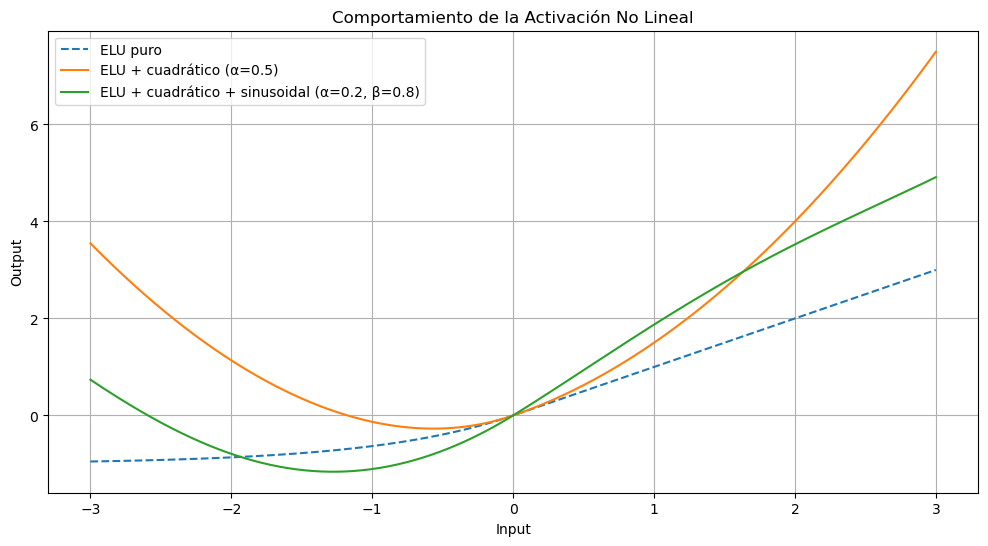

In [20]:
import numpy as np
import matplotlib.pyplot as plt

class NonlinearActivation(layers.Layer):
    def __init__(self, **kwargs):
        super(NonlinearActivation, self).__init__(**kwargs)
        # Parámetros aprendibles
        self.alpha = self.add_weight(name='alpha', shape=(1,), initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(1,), initializer='zeros', trainable=True)
    
    def call(self, inputs):
        # Función de activación compuesta
        return tf.nn.elu(inputs) + self.alpha * tf.square(inputs) + self.beta * tf.sin(inputs)

# Crear instancia de la capa
nl_layer = NonlinearActivation()

# Rango de valores de entrada
x = np.linspace(-3, 3, 500)

# Evaluar con diferentes parámetros
plt.figure(figsize=(12, 6))

# Caso 1: Comportamiento ELU puro (alpha=0, beta=0)
nl_layer.alpha.assign([0])
nl_layer.beta.assign([0])
plt.plot(x, nl_layer(x), label='ELU puro', linestyle='--')

# Caso 2: Dominio cuadrático (alpha=0.5, beta=0)
nl_layer.alpha.assign([0.5])
nl_layer.beta.assign([0])
plt.plot(x, nl_layer(x), label='ELU + cuadrático (α=0.5)')

# Caso 3: Comportamiento oscilatorio (alpha=0.2, beta=0.8)
nl_layer.alpha.assign([0.2])
nl_layer.beta.assign([0.8])
plt.plot(x, nl_layer(x), label='ELU + cuadrático + sinusoidal (α=0.2, β=0.8)')

plt.title("Comportamiento de la Activación No Lineal")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
class NonlinearActivation(layers.Layer):
    def __init__(self, **kwargs):
        super(NonlinearActivation, self).__init__(**kwargs)
        # Parámetros aprendibles
        self.alpha = self.add_weight(name='alpha', shape=(1,), initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(1,), initializer='zeros', trainable=True)
    
    def call(self, inputs):
        # Función de activación compuesta
        return tf.nn.elu(inputs) + self.alpha * tf.square(inputs) + self.beta * tf.sin(inputs)

def NonLineal_build_crn_with_skip_connections(input_shape=(None,161,2)):
    inputs = layers.Input(shape=input_shape)

    # Bloque convolucional
    conv1 = layers.Conv2D(16, (1, 3), strides=(1, 2), padding='valid')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = NonlinearActivation()(conv1)  # Capa personalizada de no linealidad
    conv2 = layers.Conv2D(32, (1, 3), strides=(1, 2), padding='valid')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = NonlinearActivation()(conv2)  # Capa personalizada de no linealidad
    conv3 = layers.Conv2D(64, (1, 3), strides=(1, 2), padding='valid')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = NonlinearActivation()(conv3)  # Capa personalizada de no linealidad
    conv4 = layers.Conv2D(128, (1, 3), strides=(1, 2), padding='valid')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = NonlinearActivation()(conv4)  # Capa personalizada de no linealidad
    conv5 = layers.Conv2D(256, (1, 3), strides=(1, 2), padding='valid')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = NonlinearActivation()(conv5)  # Capa personalizada de no linealidad
    shape = tf.keras.backend.int_shape(conv5)


    # Guardamos las capas convolucionales para las skip connections
    skip_connection_1 = conv1
    skip_connection_2 = conv2
    skip_connection_3 = conv3
    skip_connection_4 = conv4

    # Redimensionamos para las capas LSTM
    shape = tf.keras.backend.int_shape(conv5)

    #x = layers.Reshape((shape[1],shape[2] * shape[3]))(conv5)  # (batch_size, time, features)
    x = layers.Reshape((-1,shape[2] * shape[3]))(conv5)  # (batch_size, time, features)

    # Capas LSTM agrupadas
    x = layers.LSTM(1024, return_sequences=True)(x)
    x = layers.LSTM(1024, return_sequences=True)(x)

    # Redimensionamos nuevamente para las capas deconvolucionales

    #x = layers.Reshape((shape[1], shape[2], shape[3] ))(x)
    x = layers.Reshape((-1, shape[2], shape[3] ))(x)



    # Bloque deconvolucional con Skip Connections
    deconv1 = layers.Conv2DTranspose(128, (1, 3), strides=(1, 2), padding='valid')(x)
    deconv1 = layers.BatchNormalization()(deconv1)
    deconv1 = NonlinearActivation()(deconv1)
    deconv1 = layers.Add()([deconv1, skip_connection_4])  # Skip connection

    deconv2 = layers.Conv2DTranspose(64, (1, 3), strides=(1, 2), padding='valid')(deconv1)
    deconv2 = layers.BatchNormalization()(deconv2)
    deconv2 = NonlinearActivation()(deconv2)
    deconv2 = layers.Add()([deconv2, skip_connection_3])  # Skip connection

    deconv3 = layers.Conv2DTranspose(32, (1, 3), strides=(1, 2), padding='valid', activation='relu')(deconv2)
    deconv3 = layers.BatchNormalization()(deconv3)
    deconv3 = NonlinearActivation()(deconv3)
    deconv3 = layers.Add()([deconv3, skip_connection_2])  # Skip connection

    deconv4 = layers.Conv2DTranspose(16, (1, 3), strides=(1, 2), padding='valid', activation='relu')(deconv3)
    deconv4 = layers.BatchNormalization()(deconv4)
    deconv4 = NonlinearActivation()(deconv4)
    padding = [[0, 0],  # No cambiar la dimensión del batch (None/batch_size)
           [0, 0],  # No cambiar la segunda dimensión
           [0, 1],  # Agregar 1 al final de la tercera dimensión
           [0, 0]]  # No cambiar la cuarta dimensión


    deconv4 = tf.keras.layers.ZeroPadding2D(padding=(0,1))(deconv4)
    deconv4 = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(deconv4)
    deconv4 = layers.Add()([deconv4, skip_connection_1])  # Skip connection

    outputs = layers.Conv2DTranspose(2, (1, 3), strides=(1, 2), padding='valid')(deconv4)


    # Modelo
    model = models.Model(inputs, outputs)
    return model

# Crear el modelo
model = NonLineal_build_crn_with_skip_connections(input_shape=(None,161,2))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 161,   0           []                               
                                2)]                                                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, 80, 16  112         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, None, 80, 16  64         ['conv2d_5[0][0]']               
 rmalization)                   )                                                           

In [26]:
# Aplicamos la función de pérdidas personalizada, compilamos el modelo y preparamos los generadores
loss_fn = custom_loss(s_rir2)
#model.compile(optimizer='adam', loss=loss_fn)
model.compile(optimizer=Adam(learning_rate=0.001, amsgrad=True), loss=loss_fn)

In [27]:
# Cargamos los generadores de datos
batch_size_train=1
batch_size_val=1
train_gen = data_generator(p_rir,batch_size_train)
val_gen = data_generator(p_rir,batch_size_val)




In [28]:
if not os.path.exists(PATH):
    os.makedirs(PATH)
MODEL_PATH = os.path.join(PATH, f"ANCfrequency_weighted_loss.keras")
CSV_LOG_PATH = os.path.join(PATH, f"ANCfrequency_weighted_loss.csv")

# Definnimos callbacks
cbs = [
    callbacks.ModelCheckpoint(MODEL_PATH, "val_loss", save_best_only=True, mode="max"),
    callbacks.ReduceLROnPlateau(factor=0.90, patience=3),
    callbacks.CSVLogger(CSV_LOG_PATH),
]

In [32]:
# Entrenamos el modelo
# En el artículo entrenan con 20000 señales y 30 épocas. Con el valor de batch_size_train=1 sería lo equivalente a steps_per_epoch=20000, epochs=30

historia = model.fit(train_gen, steps_per_epoch=200, epochs=10, validation_data = val_gen, validation_steps=3, callbacks=cbs) # , validation_data = val_gen, validation_steps=3
print("Modelo Entrenado con Exito")

Epoch 1/10
200/200 [==============================] - 19s 93ms/step - loss: 0.2238 - val_loss: 0.2159 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - 19s 93ms/step - loss: 0.2073 - val_loss: 0.2174 - lr: 0.0010
Epoch 3/10
200/200 [==============================] - 19s 95ms/step - loss: 0.1882 - val_loss: 0.1964 - lr: 0.0010
Epoch 4/10
200/200 [==============================] - 19s 93ms/step - loss: 0.1784 - val_loss: 0.1773 - lr: 0.0010
Epoch 5/10
200/200 [==============================] - 19s 93ms/step - loss: 0.1695 - val_loss: 0.1647 - lr: 0.0010
Epoch 6/10
200/200 [==============================] - 19s 93ms/step - loss: 0.1612 - val_loss: 0.1639 - lr: 0.0010
Epoch 7/10
200/200 [==============================] - 19s 93ms/step - loss: 0.1516 - val_loss: 0.1598 - lr: 0.0010
Epoch 8/10
200/200 [==============================] - 19s 94ms/step - loss: 0.1421 - val_loss: 0.1403 - lr: 0.0010
Epoch 9/10
200/200 [==============================] - 18s 92ms/step - loss: 0.13

Power Reduction (PR): -2.51 dB


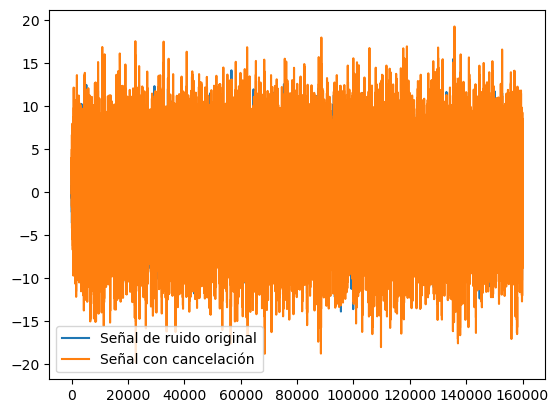

In [33]:
# Comprobamos las prestaciones mediante procesado off-line

x = tf.random.normal([fs*10]) # Creamos una señal de referencia
frame_length = int(B*fs)  # Tamaño de la ventana (en muestras)
frame_step = int(H*fs)    # Paso entre ventanas (solape del 50%)
pad_size_x = frame_length // 2
padded_x = tf.pad(x, [[pad_size_x, pad_size_x]], mode="CONSTANT")
stft_result = tf.signal.stft(padded_x, frame_length=frame_length, frame_step=frame_step,
              fft_length=frame_length, window_fn=tf.signal.hann_window) # window_fn = None
real_stft=tf.math.real(stft_result)
imag_stft=tf.math.imag(stft_result)
x_in=tf.stack((real_stft, imag_stft),axis=0)
x_in = tf.expand_dims(x_in, axis=0)
x_in = tf.transpose(x_in, perm=[0, 2, 3,1])


d1 = np.array([signal.lfilter(p_rir,1,x.numpy().flatten())])  # Simulamos propagación (obtnemos señal de ruido)

y1 = model.predict(x_in,verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz

y_pred_c = tf.complex(y1[:,:,:,0], y1[:,:,:,1])
        # Realizamos las istft
y_rec = tf.signal.inverse_stft(
        y_pred_c,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length,
        window_fn=tf.signal.inverse_stft_window_fn(frame_step)
        )
        # Recortamos la parte rellenada en el generador

y_rec = y_rec[:,pad_size_x:-pad_size_x]
y = y_rec.numpy().flatten()

d1_e = signal.lfilter(s_rir,1,y)  # Simulamos la propagación acústica de la señal generada


plt.plot(d1.flatten())
plt.plot(d1.flatten() + d1_e)  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);

# 4. Cálculo de métricas
def calculate_pr(original, cancelled):
    power_original = np.mean(original**2)
    power_cancelled = np.mean(cancelled**2)
    return 10 * np.log10(power_original / power_cancelled) if power_cancelled > 0 else 0

# Señal original de ruido
original = d1.flatten()

# Señal tras cancelación (lo que recibe el micrófono)
cancelled = (d1 + d1_e).flatten()

# Cálculo de la reducción de potencia
pr_db = calculate_pr(original, cancelled)

print(f"Power Reduction (PR): {pr_db:.2f} dB")


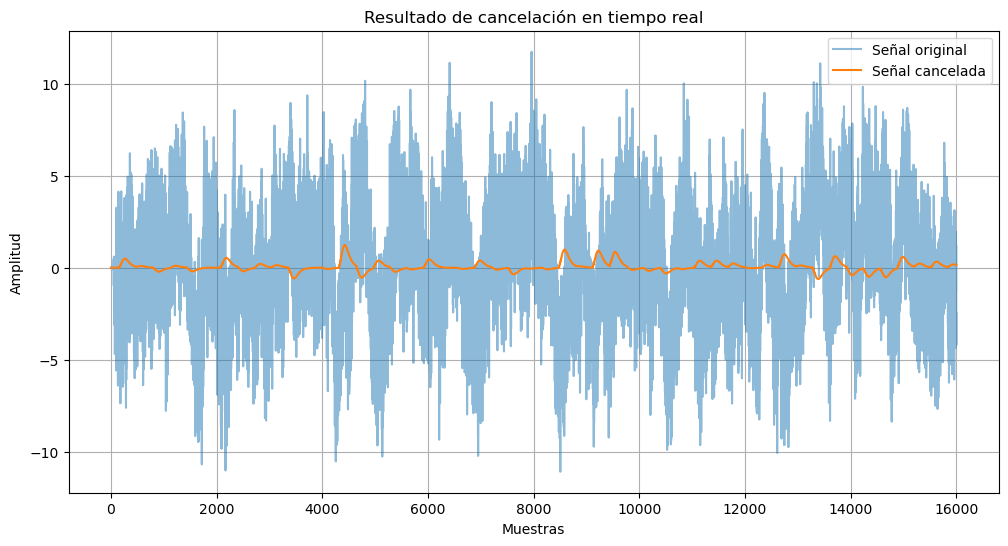

Power Reduction (PR): 21.90 dB
Señal original (sin cancelación):



Cancelación tiempo real:



Comparación A/B (alterna original y tiempo real):


In [34]:
#s_rir=s_rir[0:541] 
#s_rir = np.concatenate((np.zeros(160),s_rir))*0
class RealTimeANCPipeline:
    def __init__(self, model, p_rir, s_rir, fs=16000, B=0.020, H=0.010):
        self.model = model
        self.p_rir = p_rir
        self.s_rir = s_rir
        self.fs = fs
        self.B = B
        self.H = H

        # Configuración de STFT
        self.frame_length = int(B * fs)  # 320 muestras para 20ms a 16kHz
        self.hop_length = int(H * fs)    # 160 muestras para 10ms
        self.n_fft = self.frame_length
        self.n_freqs = self.n_fft // 2 + 1  # 161 frecuencias para 320 puntos FFT

        # Buffers
        self.input_buffer = np.zeros(self.frame_length)
        self.input_pointer = 0

        # Buffer de salida
        self.output_buffer = np.zeros(self.hop_length)
        self.output_pointer = 0
        self.valid_output_samples = 0

        # Estado del filtro
        self.filter_state = np.zeros(len(s_rir)-1)

        # Ventana Hann precalculada
        self.window = np.hanning(self.frame_length)

    def process_sample(self, x_n):
        # 1. Almacenar muestra en el buffer circular de entrada
        self.input_buffer[self.input_pointer] = x_n
        self.input_pointer = (self.input_pointer + 1) % self.frame_length

        # 2. Procesar cuando tengamos un bloque completo
        e_n = y_n = 0.0  # Valores por defecto

        if (self.input_pointer % self.hop_length == 0) and (self.input_pointer >= self.hop_length):
            # Obtener el frame actual (últimas frame_length muestras)
            if self.input_pointer >= self.frame_length:
                frame = self.input_buffer[self.input_pointer-self.frame_length:self.input_pointer]
            else:
                frame = np.concatenate([
                    self.input_buffer[self.input_pointer-self.frame_length:],
                    self.input_buffer[:self.input_pointer]
                ])

            # Aplicar ventana Hann
            frame_windowed = frame * self.window

            # Calcular STFT (sólo frecuencias positivas)
            stft = np.fft.rfft(frame_windowed, n=self.n_fft)
            real = np.real(stft).reshape(1, -1, 1)  # Formato: (1, frecuencias, 1)
            imag = np.imag(stft).reshape(1, -1, 1)

            # Preparar entrada para el modelo (batch, time, freq, channels)
            x_in = np.concatenate([real, imag], axis=-1)
            x_in = np.expand_dims(x_in, axis=0)  # Añadir dimensión de batch (1, 1, 161, 2)

            # Inferencia del modelo
            y_stft = self.model.predict(x_in, verbose=0)

            # Reconstrucción de señal
            y_pred_c = y_stft[0,:,0,0] + 1j * y_stft[0,:,0,1]
            y_block = np.fft.irfft(y_pred_c, n=self.n_fft)

            # Aplicar ventana y almacenar en buffer de salida
            y_block_windowed = y_block * self.window
            self.output_buffer = y_block_windowed[-self.hop_length:]  # Tomar las últimas hop_length muestras
            self.valid_output_samples = len(self.output_buffer)
            self.output_pointer = 0

        # 3. Obtener muestra de salida actual si hay datos disponibles
        if self.valid_output_samples > 0 and self.output_pointer < self.valid_output_samples:
            y_n = self.output_buffer[self.output_pointer]
            self.output_pointer += 1
        else:
            y_n = 0.0

        # 4. Simular propagación acústica
        d1_e_n, self.filter_state = signal.lfilter(
            self.s_rir, 1,
            np.array([y_n]),
            zi=self.filter_state
        )

        # 5. Simular micrófono
        d_n = signal.lfilter(self.p_rir, 1, np.array([x_n]))[0]
        e_n = d_n + d1_e_n[0]

        return e_n, y_n

# Función de simulación robusta
def real_time_simulation(test_signal):
    rt_anc = RealTimeANCPipeline(model, p_rir, s_rir)

    output_signal = []
    anti_noise_signal = []

    for i, x_n in enumerate(test_signal):
        try:
            e_n, y_n = rt_anc.process_sample(x_n)
            output_signal.append(e_n)
            anti_noise_signal.append(y_n)
        except Exception as e:
            print(f"Error en muestra {i}: {str(e)}")
            output_signal.append(0)
            anti_noise_signal.append(0)

    return np.array(output_signal), np.array(anti_noise_signal)

# Prueba con señal de 1 segundo (16000 muestras)
test_signal = np.random.randn(16000*1)
output, anti_noise = real_time_simulation(test_signal)

# Señal sin cancelación (ruido puro)
d_off = signal.lfilter(p_rir, 1, test_signal)

# Señal con cancelación (añadimos el anti-ruido a la propagación secundaria)
#d_on_realtime = d_off + signal.lfilter(s_rir, 1, output)

# Visualización de los primeros 1000 puntos
plt.figure(figsize=(12, 6))
plt.plot(d_off, alpha=0.5, label='Señal original')
plt.plot(output, label='Señal cancelada')
plt.legend()
plt.title('Resultado de cancelación en tiempo real')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

# 4. Cálculo de métricas
def calculate_pr(original, cancelled):
    power_original = np.mean(original**2)
    power_cancelled = np.mean(cancelled**2)
    return 10 * np.log10(power_original / power_cancelled) if power_cancelled > 0 else 0

# Señal original de ruido
original = d_off

# Señal tras cancelación (lo que recibe el micrófono)
cancelled = output

# Cálculo de la reducción de potencia
pr_db = calculate_pr(d_off, output)

print(f"Power Reduction (PR): {pr_db:.2f} dB")

def show_audio_controls(d_off, d_on_realtime, fs=16000):
    """Muestra controles de audio interactivos en Jupyter"""

    # Normalizar señales
    def normalize(x):
        return x / np.max(np.abs(x)) * 0.9

    print("Señal original (sin cancelación):")
    display(Audio(normalize(d_off.flatten()), rate=fs))

    print("\nCancelación tiempo real:")
    display(Audio(normalize(d_on_realtime.flatten()), rate=fs))

    # Comparación A/B
    ab_comparison = np.zeros(len(d_off) * 2)
    ab_comparison[::2] = d_off * 0.7
    ab_comparison[1::2] = d_on_realtime * 0.7
    print("\nComparación A/B (alterna original y tiempo real):")
    display(Audio(normalize(ab_comparison), rate=fs))

# Uso en Jupyter:
show_audio_controls(d_off, output)

=== Resultados Verificados ===
PR offline: 20.29 dB


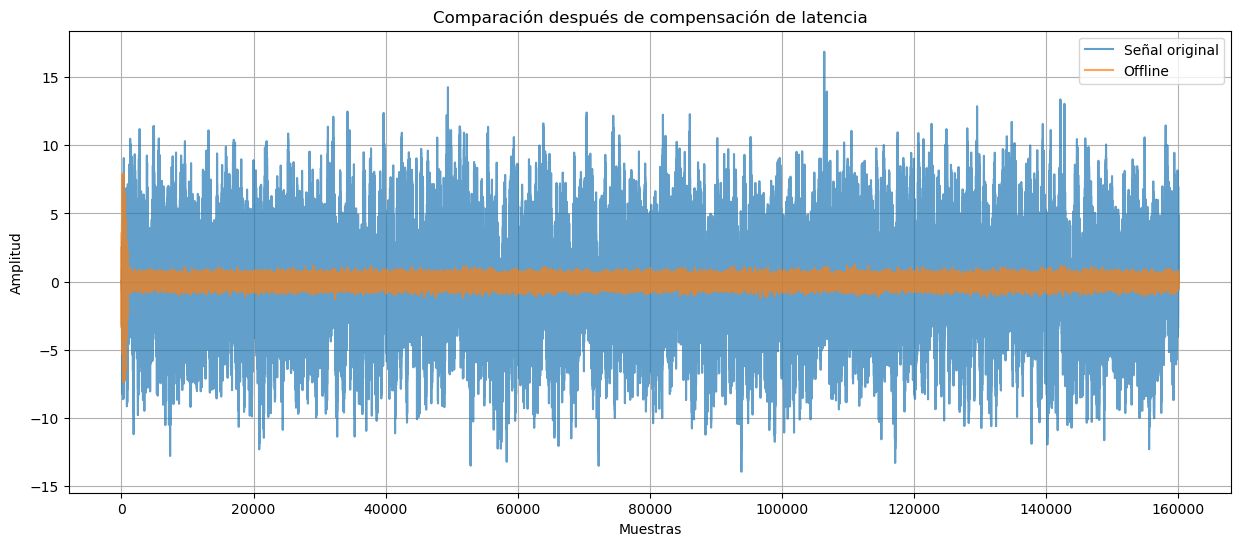

In [14]:
def offline_processing(model, p_rir, s_rir, fs=16000, duration=3, B=0.020, H=0.010):
    """Procesamiento offline completo con métricas correctas"""
    frame_length = int(B * fs)  # 320 muestras
    frame_step = int(H * fs)    # 160 muestras
    pad_size = frame_length // 2  # 160 muestras

    # 1. Generar señal de prueba
    x = np.random.randn(fs * duration)

    # 2. STFT con padding simétrico
    padded_x = np.pad(x, (pad_size, pad_size), mode='reflect')
    stft = tf.signal.stft(
        padded_x,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length,
        window_fn=tf.signal.hann_window
    )

    # 3. Preparar entrada para el modelo (batch, time, freq, channels=2)
    stft_real = tf.math.real(stft)[tf.newaxis, ..., tf.newaxis]
    stft_imag = tf.math.imag(stft)[tf.newaxis, ..., tf.newaxis]
    x_in = tf.concat([stft_real, stft_imag], axis=-1)

    # 4. Inferencia del modelo
    y_stft = model.predict(x_in, verbose=0)

    # 5. Reconstrucción de señal
    y_pred_c = tf.complex(y_stft[0, ..., 0], y_stft[0, ..., 1])
    y = tf.signal.inverse_stft(
        y_pred_c,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length,
        window_fn=tf.signal.inverse_stft_window_fn(frame_step)
    )

    # 6. Eliminar padding
    y = y[pad_size:-pad_size].numpy()

    # 7. Simulación acústica
    d_off = signal.lfilter(p_rir, 1, x)  # Señal sin cancelación
    d_on = d_off + signal.lfilter(s_rir, 1, y)  # Señal con cancelación

    # 8. Cálculo de métricas
    power_off = np.mean(d_off**2)
    power_on = np.mean(d_on**2)
    pr = 10 * np.log10(power_off / power_on) if power_on > 0 else 0

    return d_off, d_on, pr

d_off, d_on_offline, pr_offline = offline_processing(model, p_rir, s_rir, fs, 10, B, H)

print("=== Resultados Verificados ===")
print(f"PR offline: {pr_offline:.2f} dB")

# 6. Visualización
plt.figure(figsize=(15, 6))
plt.plot(d_off, label='Señal original', alpha=0.7)
plt.plot(d_on_offline, label='Offline', alpha=0.7)

plt.legend()
plt.title('Comparación después de compensación de latencia')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

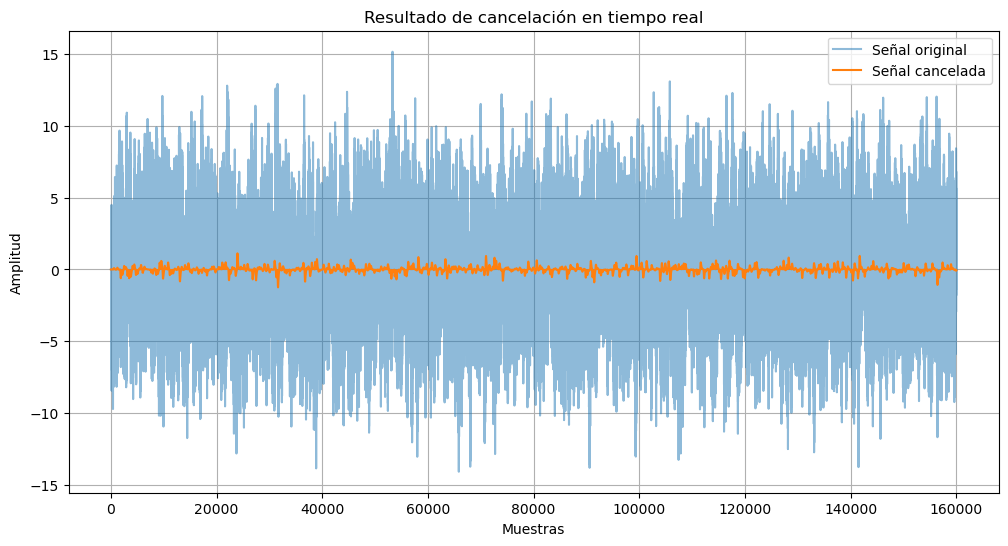

Power Reduction (PR): 24.10 dB
Señal original (sin cancelación):



Cancelación tiempo real:



Comparación A/B (alterna original y tiempo real):


In [19]:
class RealTimeANC_FairComparison:
    def __init__(self, model, p_rir, s_rir, fs=16000, B=0.020, H=0.010):
        self.model = model
        self.p_rir = p_rir
        self.s_rir = s_rir
        self.fs = fs
        self.B = B
        self.H = H

        # Configuración de STFT
        self.frame_length = int(B * fs)  # 320 muestras para 20ms a 16kHz
        self.hop_length = int(H * fs)    # 160 muestras para 10ms
        self.n_fft = self.frame_length
        self.n_freqs = self.n_fft // 2 + 1  # 161 frecuencias para 320 puntos FFT

        # Buffers
        self.input_buffer = np.zeros(self.frame_length)
        self.input_pointer = 0

        # Buffer de salida
        self.output_buffer = np.zeros(self.hop_length)
        self.output_pointer = 0
        self.valid_output_samples = 0

        # Estado del filtro
        self.filter_state = np.zeros(len(s_rir)-1)

        # Ventana Hann precalculada
        self.window = np.hanning(self.frame_length)
        self.initial_padding = np.zeros(self.frame_length)  # Padding inicial
        self.initial_samples_processed = 0
        self.warmup_frames = 3  # Descartar primeros frames
        self.processed_frames = 0

    def process_sample(self, x_n):
        # Fase inicial: acumular padding
        if self.initial_samples_processed < self.frame_length:
            self.initial_padding[self.initial_samples_processed] = x_n
            self.initial_samples_processed += 1
            return 0.0, 0.0  # No procesar hasta tener contexto
        
        # Resto igual pero usando padding inicial
        if self.input_pointer == 0:  # Primer frame real
            frame = np.concatenate([
                self.initial_padding[-self.frame_length:],
                self.input_buffer[:self.input_pointer]
            ])
        else:
            frame = self.input_buffer[self.input_pointer-self.frame_length:self.input_pointer]
        # 1. Almacenar muestra en el buffer circular de entrada
        self.input_buffer[self.input_pointer] = x_n
        self.input_pointer = (self.input_pointer + 1) % self.frame_length

        # 2. Procesar cuando tengamos un bloque completo
        e_n = y_n = 0.0  # Valores por defecto

        if self.processed_frames < self.warmup_frames:
            self.processed_frames += 1
            return 0.0, 0.0  # Descarta frames iniciales

        if (self.input_pointer % self.hop_length == 0) and (self.input_pointer >= self.hop_length):
            # Obtener el frame actual (últimas frame_length muestras)
            if self.input_pointer >= self.frame_length:
                frame = self.input_buffer[self.input_pointer-self.frame_length:self.input_pointer]
            else:
                frame = np.concatenate([
                    self.input_buffer[self.input_pointer-self.frame_length:],
                    self.input_buffer[:self.input_pointer]
                ])
               
        # Aplicar ventana Hann
            frame_windowed = frame * self.window
    
            # Calcular STFT (sólo frecuencias positivas)
            stft = np.fft.rfft(frame_windowed, n=self.n_fft)
            real = np.real(stft).reshape(1, -1, 1)  # Formato: (1, frecuencias, 1)
            imag = np.imag(stft).reshape(1, -1, 1)
    
            # Preparar entrada para el modelo (batch, time, freq, channels)
            x_in = np.concatenate([real, imag], axis=-1)
            x_in = np.expand_dims(x_in, axis=0)  # Añadir dimensión de batch (1, 1, 161, 2)
    
            # Inferencia del modelo
            y_stft = self.model.predict(x_in, verbose=0)
    
            # Reconstrucción de señal
            y_pred_c = y_stft[0,:,0,0] + 1j * y_stft[0,:,0,1]
            y_block = np.fft.irfft(y_pred_c, n=self.n_fft)
    
            # Aplicar ventana y almacenar en buffer de salida
            y_block_windowed = y_block * self.window
            self.output_buffer = y_block_windowed[-self.hop_length:]  # Tomar las últimas hop_length muestras
            self.valid_output_samples = len(self.output_buffer)
            self.output_pointer = 0
    
        # 3. Obtener muestra de salida actual si hay datos disponibles
        if self.valid_output_samples > 0 and self.output_pointer < self.valid_output_samples:
            y_n = self.output_buffer[self.output_pointer]
            self.output_pointer += 1
        else:
            y_n = 0.0
    
        # 4. Simular propagación acústica
        d1_e_n, self.filter_state = signal.lfilter(
            self.s_rir, 1,
            np.array([y_n]),
            zi=self.filter_state
        )
    
        # 5. Simular micrófono
        d_n = signal.lfilter(self.p_rir, 1, np.array([x_n]))[0]
        e_n = d_n + d1_e_n[0]
    
        return e_n, y_n

# Función de simulación robusta
def real_time_simulation(test_signal):
    rt_anc = RealTimeANC_FairComparison(model, p_rir, np.concatenat(s_rir,[]))

    output_signal = []
    anti_noise_signal = []

    for i, x_n in enumerate(test_signal):
        try:
            e_n, y_n = rt_anc.process_sample(x_n)
            output_signal.append(e_n)
            anti_noise_signal.append(y_n)
        except Exception as e:
            print(f"Error en muestra {i}: {str(e)}")
            output_signal.append(0)
            anti_noise_signal.append(0)

    return np.array(output_signal), np.array(anti_noise_signal)


# Prueba con señal de 1 segundo (16000 muestras)
test_signal = np.random.randn(16000*10)
output, anti_noise = real_time_simulation(test_signal)

# Señal sin cancelación (ruido puro)
d_off = signal.lfilter(p_rir, 1, test_signal)

# Señal con cancelación (añadimos el anti-ruido a la propagación secundaria)
d_on_realtime = d_off + signal.lfilter(s_rir, 1, output)

# Visualización de los primeros 1000 puntos
plt.figure(figsize=(12, 6))
plt.plot(d_off.flatten(), alpha=0.5, label='Señal original')
plt.plot(output.flatten(), label='Señal cancelada')
plt.legend()
plt.title('Resultado de cancelación en tiempo real')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

# 4. Cálculo de métricas
def calculate_pr(original, cancelled):
    power_original = np.mean(original**2)
    power_cancelled = np.mean(cancelled**2)
    return 10 * np.log10(power_original / power_cancelled) if power_cancelled > 0 else 0

# Señal original de ruido
original = d_off.flatten()

# Señal tras cancelación (lo que recibe el micrófono)
cancelled = output.flatten()

# Cálculo de la reducción de potencia
pr_db = calculate_pr(original, cancelled)

print(f"Power Reduction (PR): {pr_db:.2f} dB")

def show_audio_controls(d_off, d_on_realtime, fs=16000):
    """Muestra controles de audio interactivos en Jupyter"""

    # Normalizar señales
    def normalize(x):
        return x / np.max(np.abs(x)) * 0.9

    print("Señal original (sin cancelación):")
    display(Audio(normalize(d_off.flatten()), rate=fs))

    print("\nCancelación tiempo real:")
    display(Audio(normalize(d_on_realtime.flatten()), rate=fs))

    # Comparación A/B
    ab_comparison = np.zeros(len(d_off) * 2)
    ab_comparison[::2] = d_off * 0.7
    ab_comparison[1::2] = d_on_realtime * 0.7
    print("\nComparación A/B (alterna original y tiempo real):")
    display(Audio(normalize(ab_comparison), rate=fs))

# Uso en Jupyter:
show_audio_controls(d_off, output)

In [21]:
# Generar señal de prueba
test_signal = np.random.randn(16000 * 3)  # 3 segundos
rt_anc = RealTimeANC_FairComparison(model, p_rir, s_rir)
# Procesamiento offline
d_off, d_on_offline, pr_offline = offline_processing(model, p_rir, s_rir, fs=16000, duration=3)

# Procesamiento tiempo real corregido
output, _ = real_time_simulation(test_signal)
d_on_realtime = d_off + signal.lfilter(s_rir, 1, output)

# Comparación después del periodo de calentamiento
latency_samples = rt_anc.frame_length + rt_anc.hop_length * rt_anc.warmup_frames
valid_samples = slice(latency_samples, None)

# Calcular diferencia
diff = np.max(np.abs(d_on_offline[valid_samples] - d_on_realtime[valid_samples]))
correlation = np.corrcoef(d_on_offline[valid_samples], d_on_realtime[valid_samples])[0, 1]

print(f"Diferencia máxima: {diff:.2e}")
print(f"Correlación: {correlation:.4f}")

Diferencia máxima: 3.47e+01
Correlación: 0.1344


In [ ]:
# Simulador de condiciones variables
def dynamic_simulator():
    positions = {
        'source': moving_position(initial=[1.5, 1, 1]),
        'speaker': moving_position(initial=[1.5, 2.5, 1])
    }
    
    while True:
        # Actualizar posiciones
        positions['source'] += np.random.normal(0, 0.01, size=3)
        
        # Recalcular RIRs en tiempo real
        p_rir, s_rir = compute_dynamic_rirs(positions)
        
        # Generar ruido no estacionario
        x = generate_nonstationary_noise()
        
        yield x, p_rir, s_rir

In [ ]:
class RealTimeANCPipelineSTFT:
    def __init__(self, model, fs, B, H, rir, buffer_duration_sec=2):
        self.model = model
        self.fs = fs
        self.B = B
        self.H = H
        self.frame_length = int(B * fs)
        self.frame_step = int(H * fs)
        self.pad_size = self.frame_length // 2
        self.rir = rir

        self.buffer_length = int(fs * buffer_duration_sec)
        self.input_buffer = np.zeros(self.buffer_length)
        self.input_pointer = 0

    def add_input_sample(self, sample):
        # Añadir muestra a buffer circular
        self.input_buffer[self.input_pointer % self.buffer_length] = sample
        self.input_pointer += 1

        # Solo procesamos si tenemos suficiente historial
        if self.input_pointer >= self.pad_size:
            return self.process_frame()
        else:
            return 0.0  # silencio mientras no hay datos suficientes

    def process_frame(self):
        center = self.input_pointer - 1
        start = center - self.pad_size
        end = center + self.pad_size

        # Ventana centrada (con padding circular)
        indices = np.arange(start, end) % self.buffer_length
        frame = self.input_buffer[indices]

        # STFT con padding explícito
        padded_frame = tf.pad(frame, [[self.pad_size, self.pad_size]])
        stft_result = tf.signal.stft(
            padded_frame,
            frame_length=self.frame_length,
            frame_step=self.frame_step,
            fft_length=self.frame_length,
            window_fn=tf.signal.hann_window
        )
        real = tf.math.real(stft_result)
        imag = tf.math.imag(stft_result)

        # Crear tensor de entrada [1, tiempo, frecuencia, 2]
        x_in = tf.stack((real, imag), axis=0)
        x_in = tf.expand_dims(x_in, axis=0)
        x_in = tf.transpose(x_in, perm=[0, 2, 3, 1])  # [1, time, freq, 2]

        # Inferencia
        y_pred = self.model.predict(x_in, verbose=False)

        # Reconstrucción
        y_pred_complex = tf.complex(y_pred[0, :, :, 0], y_pred[0, :, :, 1])
        y_rec = tf.signal.inverse_stft(
            y_pred_complex,
            frame_length=self.frame_length,
            frame_step=self.frame_step,
            fft_length=self.frame_length,
            window_fn=tf.signal.inverse_stft_window_fn(self.frame_step)
        )

        # Quitar el padding, como offline
        y_rec = y_rec[self.pad_size:-self.pad_size]

        # Devolver muestra central reconstruida
        return y_rec.numpy()[self.pad_size]

# 4. Cálculo de métricas
def calculate_pr(original, cancelled):
    power_original = np.mean(original**2)
    power_cancelled = np.mean(cancelled**2)
    return 10 * np.log10(power_original / power_cancelled) if power_cancelled > 0 else 0

# Prueba con señal de 1 segundo (16000 muestras)
duracion = 10
test_signal = np.random.randn(16000 * duracion)
pipeline = RealTimeANCPipelineSTFT(model, fs=16000, B=0.02, H=0.01, rir=s_rir, buffer_duration_sec=1)

y_rt = np.zeros_like(test_signal)
for i in range(len(test_signal)):
    y_rt[i] = pipeline.add_input_sample(test_signal[i])

# Simulación de propagación y evaluación de cancelación
d_off = signal.lfilter(p_rir, 1, test_signal)
d_rt = d_off + signal.lfilter(s_rir, 1, y_rt)

# Mostrar y comparar
plt.plot(d_off, label='Señal original')
plt.plot(d_rt, label='Señal cancelada')
plt.legend()
plt.show()

# Métrica de cancelación
pr_db = calculate_pr(d_off, d_rt)
print(f"Power Reduction (PR): {pr_db:.2f} dB")


# Señal original de ruido
original = d_off.flatten()

# Señal tras cancelación (lo que recibe el micrófono)
cancelled = d_rt.flatten()

# Cálculo de la reducción de potencia
pr_db = calculate_pr(original, cancelled)

print(f"Power Reduction (PR): {pr_db:.2f} dB")

def show_audio_controls(d_off, d_on_realtime, fs=16000):
    """Muestra controles de audio interactivos en Jupyter"""

    # Normalizar señales
    def normalize(x):
        return x / np.max(np.abs(x)) * 0.9

    print("Señal original (sin cancelación):")
    display(Audio(normalize(d_off.flatten()), rate=fs))

    print("\nCancelación tiempo real:")
    display(Audio(normalize(d_on_realtime.flatten()), rate=fs))

    # Comparación A/B
    ab_comparison = np.zeros(len(d_off) * 2)
    ab_comparison[::2] = d_off * 0.7
    ab_comparison[1::2] = d_on_realtime * 0.7
    print("\nComparación A/B (alterna original y tiempo real):")
    display(Audio(normalize(ab_comparison), rate=fs))

# Uso en Jupyter:
show_audio_controls(d_off, d_rt)

In [ ]:
### Modelo sin LSTM

from tensorflow.keras import layers, models
import tensorflow as tf

def build_crn_without_lstm(input_shape=(None, 161, 2)):
    inputs = layers.Input(shape=input_shape)

    # Bloque convolucional
    conv1 = layers.Conv2D(16, (1, 3), strides=(1, 2), padding='valid')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('elu')(conv1)

    conv2 = layers.Conv2D(32, (1, 3), strides=(1, 2), padding='valid')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('elu')(conv2)

    conv3 = layers.Conv2D(64, (1, 3), strides=(1, 2), padding='valid')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('elu')(conv3)

    conv4 = layers.Conv2D(128, (1, 3), strides=(1, 2), padding='valid')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('elu')(conv4)

    conv5 = layers.Conv2D(256, (1, 3), strides=(1, 2), padding='valid')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('elu')(conv5)

    # Guardamos las capas convolucionales para las skip connections
    skip_connection_1 = conv1
    skip_connection_2 = conv2
    skip_connection_3 = conv3
    skip_connection_4 = conv4

    # Bloque deconvolucional con Skip Connections
    deconv1 = layers.Conv2DTranspose(128, (1, 3), strides=(1, 2), padding='valid')(conv5)
    deconv1 = layers.BatchNormalization()(deconv1)
    deconv1 = layers.Activation('elu')(deconv1)
    deconv1 = layers.Add()([deconv1, skip_connection_4])  # Skip connection

    deconv2 = layers.Conv2DTranspose(64, (1, 3), strides=(1, 2), padding='valid')(deconv1)
    deconv2 = layers.BatchNormalization()(deconv2)
    deconv2 = layers.Activation('elu')(deconv2)
    deconv2 = layers.Add()([deconv2, skip_connection_3])  # Skip connection

    deconv3 = layers.Conv2DTranspose(32, (1, 3), strides=(1, 2), padding='valid')(deconv2)
    deconv3 = layers.BatchNormalization()(deconv3)
    deconv3 = layers.Activation('elu')(deconv3)
    deconv3 = layers.Add()([deconv3, skip_connection_2])  # Skip connection

    deconv4 = layers.Conv2DTranspose(16, (1, 3), strides=(1, 2), padding='valid')(deconv3)
    deconv4 = layers.BatchNormalization()(deconv4)
    deconv4 = layers.Activation('elu')(deconv4)

    # Ajustamos las dimensiones con padding y cropping para que coincidan con el skip_connection_1
    deconv4 = tf.keras.layers.ZeroPadding2D(padding=(0, 1))(deconv4)
    deconv4 = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(deconv4)
    deconv4 = layers.Add()([deconv4, skip_connection_1])  # Skip connection

    outputs = layers.Conv2DTranspose(2, (1, 3), strides=(1, 2), padding='valid')(deconv4)

    # Modelo
    model = models.Model(inputs, outputs)
    return model

# Crear el modelo
model = build_crn_without_lstm(input_shape=(None, 161, 2))

# Resumen del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 161, 2)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, 80, 16)   │            112 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, 80, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, 80, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, 39, 32)   │          1,568 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, 39, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, 39, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, 19, 64)   │          6,208 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, 19, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, 19, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, 9, 128)   │         24,704 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, 9, 128)   │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, 9, 128)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, 4, 256)   │         98,560 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, 4, 256)   │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, None, 4, 256)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, None, 9, 128)   │         98,432 │ activation_4[0][0]     │
│ (Conv2DTranspose)    

 Total params: 264,994 (1.01 MB)

 Trainable params: 263,522 (1.01 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# Aplicamos la función de pérdidas personalizada, compilamos el modelo y preparamos los generadores
loss_fn = custom_loss(s_rir)
#model.compile(optimizer='adam', loss=loss_fn)
model.compile(optimizer=Adam(learning_rate=0.001, amsgrad=True), loss=loss_fn)

In [ ]:
# Cargamos los generadores de datos
batch_size_train=1
batch_size_val=1
train_gen = data_generator(p_rir,batch_size_train)
val_gen = data_generator(p_rir,batch_size_val)


In [ ]:
# Entrenamos el modelo
# En el artículo entrenan con 20000 señales y 30 épocas. Con el valor de batch_size_train=1 sería lo equivalente a steps_per_epoch=20000, epochs=30
historia = model.fit(train_gen, steps_per_epoch=500, epochs=10, validation_data = val_gen, validation_steps=3) # , validation_data = val_gen, validation_steps=3

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 5.6910 - val_loss: 2.6568
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 2.5000 - val_loss: 2.2028
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 2.1546 - val_loss: 2.0851
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 2.0480 - val_loss: 2.0259
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 1.9741 - val_loss: 1.8902
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 1.8155 - val_loss: 1.7045
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1.6833 - val_loss: 1.6511
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1.6084 - val_loss: 1.5853
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1.5625 - val_loss: 1.5800
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1.5333 - val_loss: 1.5442


SNR antes de la cancelación: 0.00 dB
SNR después de la cancelación: 0.79 dB


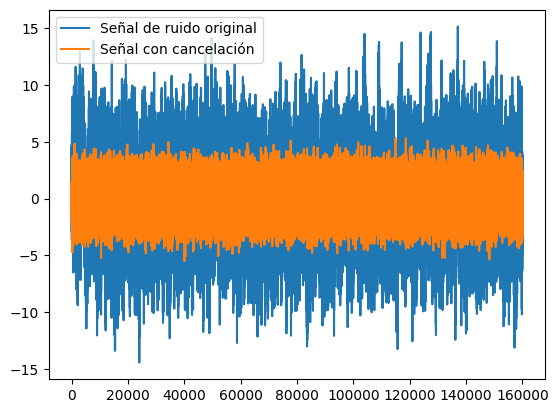

In [ ]:
# Comprobamos las prestaciones mediante procesado off-line


x = tf.random.normal([fs*10]) # Creamos una señal de referencia
frame_length = int(B*fs)  # Tamaño de la ventana (en muestras)
frame_step = int(H*fs)    # Paso entre ventanas (solape del 50%)
pad_size_x = frame_length // 2
padded_x = tf.pad(x, [[pad_size_x, pad_size_x]], mode="CONSTANT")
stft_result = tf.signal.stft(padded_x, frame_length=frame_length, frame_step=frame_step,
              fft_length=frame_length, window_fn=tf.signal.hann_window) # window_fn = None
real_stft=tf.math.real(stft_result)
imag_stft=tf.math.imag(stft_result)
x_in=tf.stack((real_stft, imag_stft),axis=0)
x_in = tf.expand_dims(x_in, axis=0)
x_in = tf.transpose(x_in, perm=[0, 2, 3,1])


d1 = np.array([signal.lfilter(p_rir,1,x.numpy().flatten())])  # Simulamos propagación (obtnemos señal de ruido)



y1 = model.predict(x_in,verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz

y_pred_c = tf.complex(y1[:,:,:,0], y1[:,:,:,1])
        # Realizamos las istft
y_rec = tf.signal.inverse_stft(
        y_pred_c,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length,
        window_fn=tf.signal.inverse_stft_window_fn(frame_step)
        )
        # Recortamos la parte rellenada en el generador

y_rec = y_rec[:,pad_size_x:-pad_size_x]
y = y_rec.numpy().flatten()

d1_e = signal.lfilter(s_rir,1,y)  # Simulamos la propagación acústica de la señal generada


plt.plot(d1.flatten())
plt.plot(d1.flatten() + d1_e)  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);
def calculate_snr(original_signal, processed_signal):
    noise = original_signal - processed_signal
    snr = 10 * np.log10(np.mean(original_signal**2) / np.mean(noise**2))
    return snr

snr_before = calculate_snr(d1.flatten(), np.zeros_like(d1.flatten()))
snr_after = calculate_snr(d1.flatten(), (d1.flatten() + d1_e))
print(f"SNR antes de la cancelación: {snr_before:.2f} dB")
print(f"SNR después de la cancelación: {snr_after:.2f} dB")

In [ ]:
### Modelo reducioendo las neuronas


def build_crn_with_skip_connections(input_shape=(None,161,2)):
    inputs = layers.Input(shape=input_shape)

    # Bloque convolucional con menos filtros
    conv1 = layers.Conv2D(8, (1, 3), strides=(1, 2), padding='valid')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('elu')(conv1)
    conv2 = layers.Conv2D(16, (1, 3), strides=(1, 2), padding='valid')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('elu')(conv2)
    conv3 = layers.Conv2D(32, (1, 3), strides=(1, 2), padding='valid')(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('elu')(conv3)
    conv4 = layers.Conv2D(64, (1, 3), strides=(1, 2), padding='valid')(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('elu')(conv4)
    conv5 = layers.Conv2D(128, (1, 3), strides=(1, 2), padding='valid')(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('elu')(conv5)
    shape = tf.keras.backend.int_shape(conv5)


    # Guardamos las capas convolucionales para las skip connections
    skip_connection_1 = conv1
    skip_connection_2 = conv2
    skip_connection_3 = conv3
    skip_connection_4 = conv4

    # Redimensionamos para las capas LSTM
    shape = tf.keras.backend.int_shape(conv5)

    #x = layers.Reshape((shape[1],shape[2] * shape[3]))(conv5)  # (batch_size, time, features)
    x = layers.Reshape((-1,shape[2] * shape[3]))(conv5)  # (batch_size, time, features)

    # Capas LSTM con menos neuronas
    x = layers.LSTM(512, return_sequences=True)(x)
    x = layers.LSTM(512, return_sequences=True)(x)

    # Redimensionamos nuevamente para las capas deconvolucionales
    #x = layers.Reshape((shape[1], shape[2], shape[3] ))(x)
    x = layers.Reshape((-1, shape[2], shape[3] ))(x)

    # Bloque deconvolucional con Skip Connections y menos filtros
    deconv1 = layers.Conv2DTranspose(64, (1, 3), strides=(1, 2), padding='valid')(x)
    deconv1 = layers.BatchNormalization()(deconv1)
    deconv1 = layers.Activation('elu')(deconv1)
    deconv1 = layers.Add()([deconv1, skip_connection_4])  # Skip connection

    deconv2 = layers.Conv2DTranspose(32, (1, 3), strides=(1, 2), padding='valid')(deconv1)
    deconv2 = layers.BatchNormalization()(deconv2)
    deconv2 = layers.Activation('elu')(deconv2)
    deconv2 = layers.Add()([deconv2, skip_connection_3])  # Skip connection

    deconv3 = layers.Conv2DTranspose(16, (1, 3), strides=(1, 2), padding='valid', activation='relu')(deconv2)
    deconv3 = layers.BatchNormalization()(deconv3)
    deconv3 = layers.Activation('elu')(deconv3)
    deconv3 = layers.Add()([deconv3, skip_connection_2])  # Skip connection

    deconv4 = layers.Conv2DTranspose(8, (1, 3), strides=(1, 2), padding='valid', activation='relu')(deconv3)
    deconv4 = layers.BatchNormalization()(deconv4)
    deconv4 = layers.Activation('elu')(deconv4)
    padding = [[0, 0],  # No cambiar la dimensión del batch (None/batch_size)
               [0, 0],  # No cambiar la segunda dimensión
               [0, 1],  # Agregar 1 al final de la tercera dimensión
               [0, 0]]  # No cambiar la cuarta dimensión

    deconv4 = tf.keras.layers.ZeroPadding2D(padding=(0,1))(deconv4)
    deconv4 = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(deconv4)
    deconv4 = layers.Add()([deconv4, skip_connection_1])  # Skip connection

    outputs = layers.Conv2DTranspose(2, (1, 3), strides=(1, 2), padding='valid')(deconv4)

    # Modelo
    model = models.Model(inputs, outputs)
    return model

# Crear el modelo con menos neuronas
model = build_crn_with_skip_connections(input_shape=(None,161,2))


In [ ]:
# Aplicamos la función de pérdidas personalizada, compilamos el modelo y preparamos los generadores
loss_fn = custom_loss(s_rir)
#model.compile(optimizer='adam', loss=loss_fn)
model.compile(optimizer=Adam(learning_rate=0.001, amsgrad=True), loss=loss_fn)

In [ ]:
# Cargamos los generadores de datos
batch_size_train=1
batch_size_val=1
train_gen = data_generator(p_rir,batch_size_train)
val_gen = data_generator(p_rir,batch_size_val)


In [ ]:
# Entrenamos el modelo
# En el artículo entrenan con 20000 señales y 30 épocas. Con el valor de batch_size_train=1 sería lo equivalente a steps_per_epoch=20000, epochs=30
historia = model.fit(train_gen, steps_per_epoch=500, epochs=10, validation_data = val_gen, validation_steps=3) # , validation_data = val_gen, validation_steps=3
''' Comparamos con el modelo con el doble de nueronas:
Epoch 1/10
500/500 [==============================] - 64s 90ms/step - loss: 3.6585 - val_loss: 1.5611
Epoch 2/10
500/500 [==============================] - 44s 88ms/step - loss: 1.0271 - val_loss: 0.6965
Epoch 3/10
500/500 [==============================] - 44s 88ms/step - loss: 0.4584 - val_loss: 0.3690
Epoch 4/10
500/500 [==============================] - 44s 88ms/step - loss: 0.2667 - val_loss: 0.2347
Epoch 5/10
500/500 [==============================] - 45s 90ms/step - loss: 0.1861 - val_loss: 0.1698
Epoch 6/10
500/500 [==============================] - 44s 89ms/step - loss: 0.1440 - val_loss: 0.1348
Epoch 7/10
500/500 [==============================] - 44s 87ms/step - loss: 0.1199 - val_loss: 0.1096
Epoch 8/10
500/500 [==============================] - 44s 88ms/step - loss: 0.1039 - val_loss: 0.0899
Epoch 9/10
500/500 [==============================] - 42s 84ms/step - loss: 0.0934 - val_loss: 0.0832
Epoch 10/10
500/500 [==============================] - 42s 84ms/step - loss: 0.0837 - val_loss: 0.0778'''

Epoch 1/10
500/500 [==============================] - 40s 71ms/step - loss: 5.0220 - val_loss: 3.3496
Epoch 2/10
500/500 [==============================] - 35s 71ms/step - loss: 2.4651 - val_loss: 1.8156
Epoch 3/10
500/500 [==============================] - 34s 68ms/step - loss: 1.2142 - val_loss: 1.0324
Epoch 4/10
500/500 [==============================] - 34s 68ms/step - loss: 0.6641 - val_loss: 0.6478
Epoch 5/10
500/500 [==============================] - 35s 69ms/step - loss: 0.4165 - val_loss: 0.4310
Epoch 6/10
500/500 [==============================] - 33s 65ms/step - loss: 0.2991 - val_loss: 0.2926
Epoch 7/10
500/500 [==============================] - 33s 67ms/step - loss: 0.2355 - val_loss: 0.2414
Epoch 8/10
500/500 [==============================] - 33s 67ms/step - loss: 0.2052 - val_loss: 0.2239
Epoch 9/10
500/500 [==============================] - 37s 74ms/step - loss: 0.1809 - val_loss: 0.1698
Epoch 10/10
500/500 [==============================] - 33s 66ms/step - loss: 0.162

' Comparamos con el modelo con el doble de nueronas:\nEpoch 1/10\n500/500 [==============================] - 64s 90ms/step - loss: 3.6585 - val_loss: 1.5611\nEpoch 2/10\n500/500 [==============================] - 44s 88ms/step - loss: 1.0271 - val_loss: 0.6965\nEpoch 3/10\n500/500 [==============================] - 44s 88ms/step - loss: 0.4584 - val_loss: 0.3690\nEpoch 4/10\n500/500 [==============================] - 44s 88ms/step - loss: 0.2667 - val_loss: 0.2347\nEpoch 5/10\n500/500 [==============================] - 45s 90ms/step - loss: 0.1861 - val_loss: 0.1698\nEpoch 6/10\n500/500 [==============================] - 44s 89ms/step - loss: 0.1440 - val_loss: 0.1348\nEpoch 7/10\n500/500 [==============================] - 44s 87ms/step - loss: 0.1199 - val_loss: 0.1096\nEpoch 8/10\n500/500 [==============================] - 44s 88ms/step - loss: 0.1039 - val_loss: 0.0899\nEpoch 9/10\n500/500 [==============================] - 42s 84ms/step - loss: 0.0934 - val_loss: 0.0832\nEpoch 10/1

SNR antes de la cancelación: 0.00 dB
SNR después de la cancelación: 0.15 dB


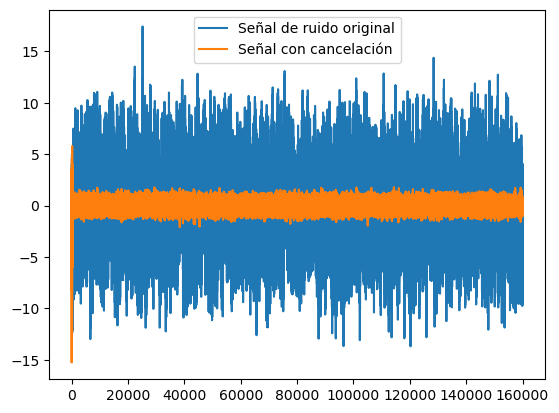

In [ ]:
# Comprobamos las prestaciones mediante procesado off-line


x = tf.random.normal([fs*10]) # Creamos una señal de referencia
frame_length = int(B*fs)  # Tamaño de la ventana (en muestras)
frame_step = int(H*fs)    # Paso entre ventanas (solape del 50%)
pad_size_x = frame_length // 2
padded_x = tf.pad(x, [[pad_size_x, pad_size_x]], mode="CONSTANT")
stft_result = tf.signal.stft(padded_x, frame_length=frame_length, frame_step=frame_step,
              fft_length=frame_length, window_fn=tf.signal.hann_window) # window_fn = None
real_stft=tf.math.real(stft_result)
imag_stft=tf.math.imag(stft_result)
x_in=tf.stack((real_stft, imag_stft),axis=0)
x_in = tf.expand_dims(x_in, axis=0)
x_in = tf.transpose(x_in, perm=[0, 2, 3,1])


d1 = np.array([signal.lfilter(p_rir,1,x.numpy().flatten())])  # Simulamos propagación (obtnemos señal de ruido)



y1 = model.predict(x_in,verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz

y_pred_c = tf.complex(y1[:,:,:,0], y1[:,:,:,1])
        # Realizamos las istft
y_rec = tf.signal.inverse_stft(
        y_pred_c,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length,
        window_fn=tf.signal.inverse_stft_window_fn(frame_step)
        )
        # Recortamos la parte rellenada en el generador

y_rec = y_rec[:,pad_size_x:-pad_size_x]
y = y_rec.numpy().flatten()

d1_e = signal.lfilter(s_rir,1,y)  # Simulamos la propagación acústica de la señal generada


plt.plot(d1.flatten())
plt.plot(d1.flatten() + d1_e)  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);
def calculate_snr(original_signal, processed_signal):
    noise = original_signal - processed_signal
    snr = 10 * np.log10(np.mean(original_signal**2) / np.mean(noise**2))
    return snr

snr_before = calculate_snr(d1.flatten(), np.zeros_like(d1.flatten()))
snr_after = calculate_snr(d1.flatten(), (d1.flatten() + d1_e))
print(f"SNR antes de la cancelación: {snr_before:.2f} dB")
print(f"SNR después de la cancelación: {snr_after:.2f} dB")